# Проект: нефтяные скважины
Мы работаем в воображаемой добывающей компании «ГлавРосГосНефть».
## Цель проекта:
Нам нужно определить, где лучше всего бурить новую скважину.

В нашем распоряжении пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерялось качество нефти и объём её запасов. Мы построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, проанализируем возможную прибыль и риски техникой *Bootstrap.*

#### Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

#### Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- Остальные условия выпишем в переменные в 3 разделе проекта.

---

## 1. Откроем и подготовим файл с данными <a id="first-look"></a>

\*Мы выполним проект оффлайн на **Mac**, и путь к датасету несколько отличается от Яндекс.Практикума. Учтём это исключение, чтобы файл исправно открывался в обоих случаях.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

In [2]:
def yandex_open(path):
    """Функция получает на вход оригинальный путь к файлу для Яндекс.Практикума.
    Если ошибка, то путь адаптируется к Mac."""
    try:
        return pd.read_csv(path)
    except FileNotFoundError:
    # Убираем "/" в пути к файлу для Mac
        return pd.read_csv(path[1:])

Откроем датасеты и сохраним их в переменные с понятными названиями, чтобы наш проект было приятнее и удобнее выполнять.

In [3]:
# Открываем csv, называем регионы
bravo, sierra, tango = [yandex_open(f'/datasets/geo_data_{i}.csv') for i in range(3)]

# Сохраним их в список для удобного обращения в дальнейшем
locs, names = (bravo, sierra, tango), ('Bravo', 'Sierra', 'Tango')
locations = tuple(zip(locs, names))

Изучим данные по регионам. Подготовим почву для отрисовки с функциями из предыдущих проектов.

In [4]:
import matplotlib.pyplot as plt, seaborn as sns

In [76]:
class Plotter:
    """Даёт доступ к функциям для удобной отрисовки, поддерживает конструкцию with...as.
    -----
    **showparams: st=None, grid=False, legend=None, tight=False
    """
    def __init__(self, x=15, y=4, **showparams):
        self.x = x
        self.y = y
        self.showparams = showparams
        
    def __enter__(self):
        self.figure(self.x, self.y)
        return self
        
    def __exit__(self, type, value, traceback):
        self.show(**self.showparams)
        
    def figure(self, x=15, y=4):
        """Инициализирует рисунок в приятном для глаза разрешении
        и оптимальном размере, который можно задать при необходимости
        """
        plt.figure(figsize=(x, y), dpi=200)

    def show(self, st=None, grid=False, legend=None, tight=False):
        """Поможет в одну строчку воспользоваться частыми функциями pyplot
        """
        if len(plt.gcf().axes) != 0:
            if tight: plt.tight_layout(pad=2.5)
            if st: plt.suptitle(st)
            if grid: plt.grid()
            if legend == 'a': plt.legend()
            if legend == 'f': plt.figlegend()
            plt.show()
        plt.close()
        
    
    @staticmethod
    def subplot(pos, title=None, sx=True):
        """Функция, которая добавляет на рисунок координатную плоскость с sharex по умолчанию
        """
        if sx:
            plt.subplot(pos, sharex=plt.gca(), title=title)
        else:
            plt.subplot(pos, title=title)
  
    @staticmethod
    def labels(x=None, y=None, x_kws=None, y_kws=None):
        """Даёт названия осям графика, kws обращаются к kwargs названий
        --------
        0 убирает названия
        """
        if x:
            plt.xlabel(x, **x_kws if x_kws else {}) if x != 0 else plt.xlabel(None)
        if y:
            plt.ylabel(y, **y_kws if y_kws else {}) if y != 0 else plt.ylabel(None)
            
    @staticmethod
    def format_axis(axis, formatter):
        """Форматирует ось форматтером из matplotlib
        """
        if axis in [0, 'x']:
            plt.gca().xaxis.set_major_formatter(formatter)
        if axis in [1, 'y']:
            plt.gca().yaxis.set_major_formatter(formatter)

Bravo
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------
head()


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


--------------------------------------------------
nunique()


id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

--------------------------------------------------
describe()


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


--------------------------------------------------
corr()


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


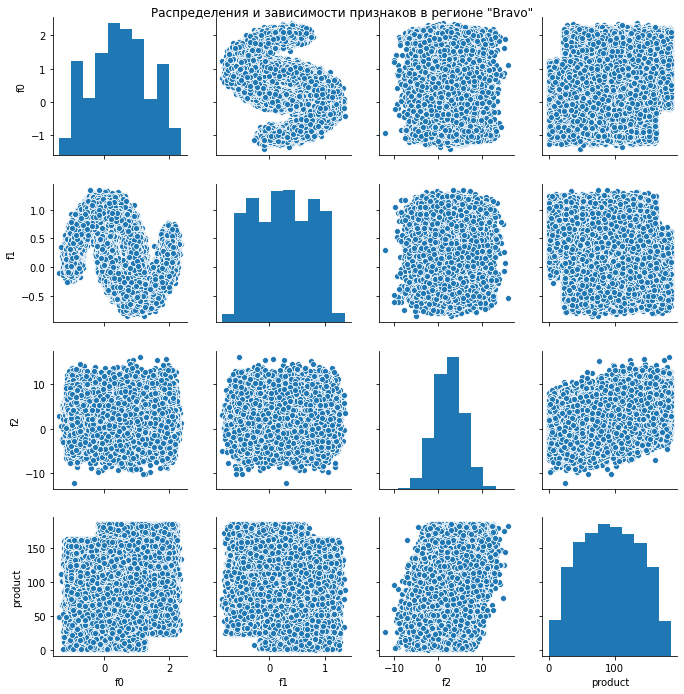


Sierra
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------
head()


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


--------------------------------------------------
nunique()


id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

--------------------------------------------------
describe()


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


--------------------------------------------------
corr()


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


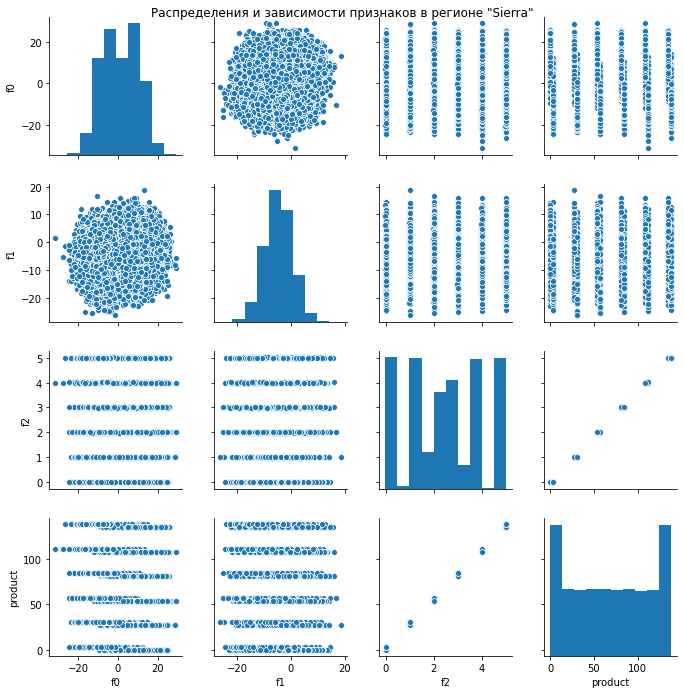


Tango
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------------
head()


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


--------------------------------------------------
nunique()


id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

--------------------------------------------------
describe()


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


--------------------------------------------------
corr()


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


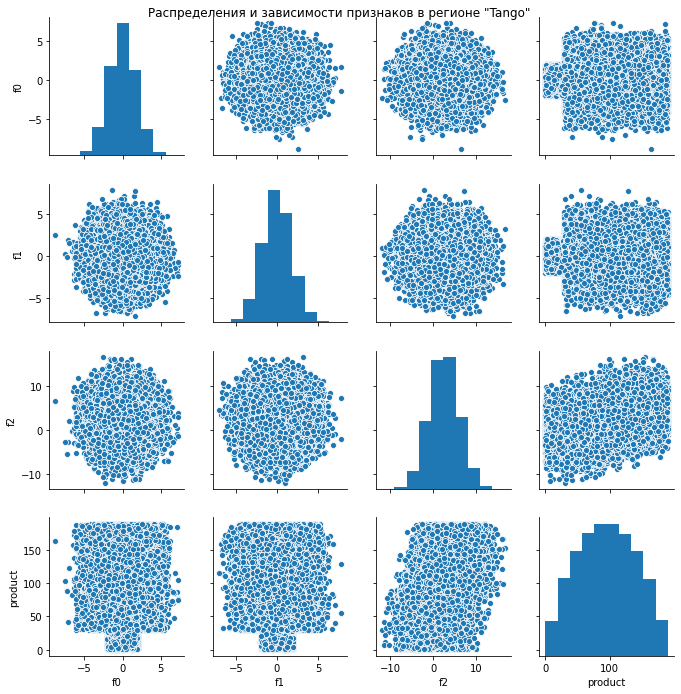

In [6]:
# Создадим отрисовщик с параметрами по умолчанию
ptr = Plotter()

# Делаем подробнейшее описание для каждого датафрейма
for loc, name in locations:
    print(name + '\n' + '-' * 50)
    loc.info()
    print('-' * 50)
    print('head()')
    display(loc.head(3))
    print('-' * 50)
    print('nunique()')
    display(loc.nunique())
    print('-' * 50)
    print('describe()')
    display(loc.describe().transpose())
    print('-' * 50)
    print('corr()')
    display(loc.corr())
    sns.pairplot(loc)
    ptr.show(st=f'Распределения и зависимости признаков в регионе "{name}"', tight=True)
    print()

Что мы выяснили:
- Каждый датасет содержит *10000* строк. Пропуски отсутствуют.
- Типы данных в столбцах вполне **соответствуют** содержащимся в них данным.
- `id` месторождений не имеют особого смысла. Тем более, что по условию данные являются синтетическими. На всякий случай просто сохраним их в **отдельные переменные** и удалим из исходных датасетов.
- Не все значения `id` в датасетах уникальны. Но мы уже решили отбросить столбец `id` как бесполезный, поэтому не будем обрабатывать дубликаты.
- Интересно, что в регионе Sierra всего *12* уникальных значений целевого признака.
- Корреляция целевого признака с фичами в большинстве случаев ничтожно мала, но есть и очень сильная корреляция. Возможно, будет смысл в том, чтобы отбросить признаки, которые вносят сумятицу в предсказания. Причём очевидно, что для каждого датасета нужна **отдельная модель**: будем считать, что одни и те же фичи во всех регионах значат что-то разное.
- Распределения признаков в основном похожи на нормальные. Хотя в регионе Sierra встречаются и явно ненормальные распределения у признака `f2` и `product`.
- Точечные диаграммы показывают несколько больше, чем корреляция. В некоторых случаях глаз улавливает некую связь между признаками: например, диаграммы связи `product` с `f0` и `f1` в регионе Bravo.

Избавимся от столбцов `id` в датасетах.

In [7]:
# Сохраним id, чтобы не потерять
bravo_ids, sierra_ids, tango_ids = [df.id for df in locs]

In [8]:
# Удалим из датафреймов
for df in locs:
    df.drop('id', axis=1, inplace=True)

In [9]:
# Проверим результат
for df in locs:
    display(df.head(1))

,f0,f1,f2,product
0,0.705745,-0.497823,1.22117,105.280062


,f0,f1,f2,product
0,-15.001348,-8.276,-0.005876,3.179103


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673


---

## 2. Обучение и проверка моделей
В этом разделе мы будем обучать модели линейной регрессии для каждого региона, чтобы предсказать запасы нефти в месторождениях по набору абстрактных признаков `f`. Основной метрикой качества наших моделей будет **RMSE**: Она более чувствительна к большим ошибкам, чем MAE.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [11]:
# Обозначим функцию RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Разделение данных на выборки
Поделим каждый датасет на фичи и целевой признак. Воспользуемся нашей заранее написанной функцией.

In [12]:
from itertools import chain

def xy_split(data, target: str, as_list=False, xs_first=False):
    """Возвращает кортеж из признаков и целевого признака.
    
    Если получает на вход список датафреймов, возвращает список кортежей.
    -----
    data - датафрейм или список датафреймов
    target - целевой признак
    as_list - Возвращает сплошной список элементов
    xs_first - сначала все x, затем y, иначе чередует.
    """
    if isinstance(data, (list, tuple)):
        if xs_first:
            l = np.transpose(xy_split(data, target))
            if as_list:
                return tuple(chain(l[0], l[1]))
            return l
        l = []
        for element in data:
            xy = xy_split(element, target)
            # Списком или кортежами
            l.extend(xy) if as_list else l.append(xy)
        return l
    return data.drop(target, axis=1), data[target]

В одно действие разделим датасеты на `x` и `y`, а затем на обучающие и валидационные выборки.

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Генераторное выражение получает список кортежей X и Y из нашей функции, а затем делит их на выборки через train_test_split
(bravo_x_train, bravo_x_val, bravo_y_train, bravo_y_val),\
(sierra_x_train, sierra_x_val, sierra_y_train, sierra_y_val),\
(tango_x_train, tango_x_val, tango_y_train, tango_y_val) = [train_test_split(x, y, test_size=0.25, random_state=0) for x, y in xy_split(locs, 'product')]

Убедимся, что выборки поделены верно.

In [15]:
for df in [bravo_x_train, bravo_x_val, bravo_y_train, bravo_y_val,
           sierra_x_train, sierra_x_val, sierra_y_train, sierra_y_val,
           tango_x_train, tango_x_val, tango_y_train, tango_y_val]:
    print(df.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)
(75000, 3)
(25000, 3)
(75000,)
(25000,)
(75000, 3)
(25000, 3)
(75000,)
(25000,)


Всё на своём месте, у нас получилось поделить всё и сразу, хотя здесь велика возможность ошибиться.

### Регион Bravo
Обучим для начала базовую модель без работы с признаками.

In [16]:
model_bravo = LinearRegression().fit(bravo_x_train, bravo_y_train)

Сделаем предсказания на валидационной выборке и посчитаем RMSE.

In [17]:
root_mean_squared_error(bravo_y_val, model_bravo.predict(bravo_x_val))

37.48100896950594

Попробуем снизить значение RMSE. Оставим только `f2` в качестве регрессора.

In [18]:
# Ссылка на pd.DataFrame
dframe = pd.DataFrame

In [19]:
model_bravo_f2 = LinearRegression().fit(dframe(bravo_x_train.f2), bravo_y_train)

In [20]:
root_mean_squared_error(bravo_y_val, model_bravo_f2.predict(dframe(bravo_x_val.f2)))

38.620833599492286

Точность снизилась. Будем придерживаться обычной модели со всеми признаками.

In [21]:
del model_bravo_f2

In [22]:
bravo_preds = pd.Series(model_bravo.predict(bravo_x_val), index=bravo_y_val.index)

In [23]:
bravo_preds.head()

3582      95.303891
60498     95.098407
53227    106.702273
21333     96.740059
3885      97.703381
dtype: float64

Обозначим функцию, которая подытожит результаты работы модели.

In [24]:
def resume(y_true, preds, graphic=False, as_dict=True, title=None):
    true_mean = np.mean(y_true)
    preds_mean = np.mean(preds)
    if graphic:
        with Plotter(st=title if title else None, legend='a'):
            sns.distplot(preds, label='Предсказания модели')
            sns.distplot(y_true, label='Правильные ответы')
            plt.axvline(preds_mean, label=f'Среднее предсказаний = {preds_mean:.3f}')
            plt.axvline(true_mean, label=f'Реальное среднее = {true_mean:.3f}', c='orange', ls='--')
    if as_dict:
        return {'rmse': root_mean_squared_error(y_true, preds),
                'preds_mean': preds_mean,
                'true_mean': true_mean}

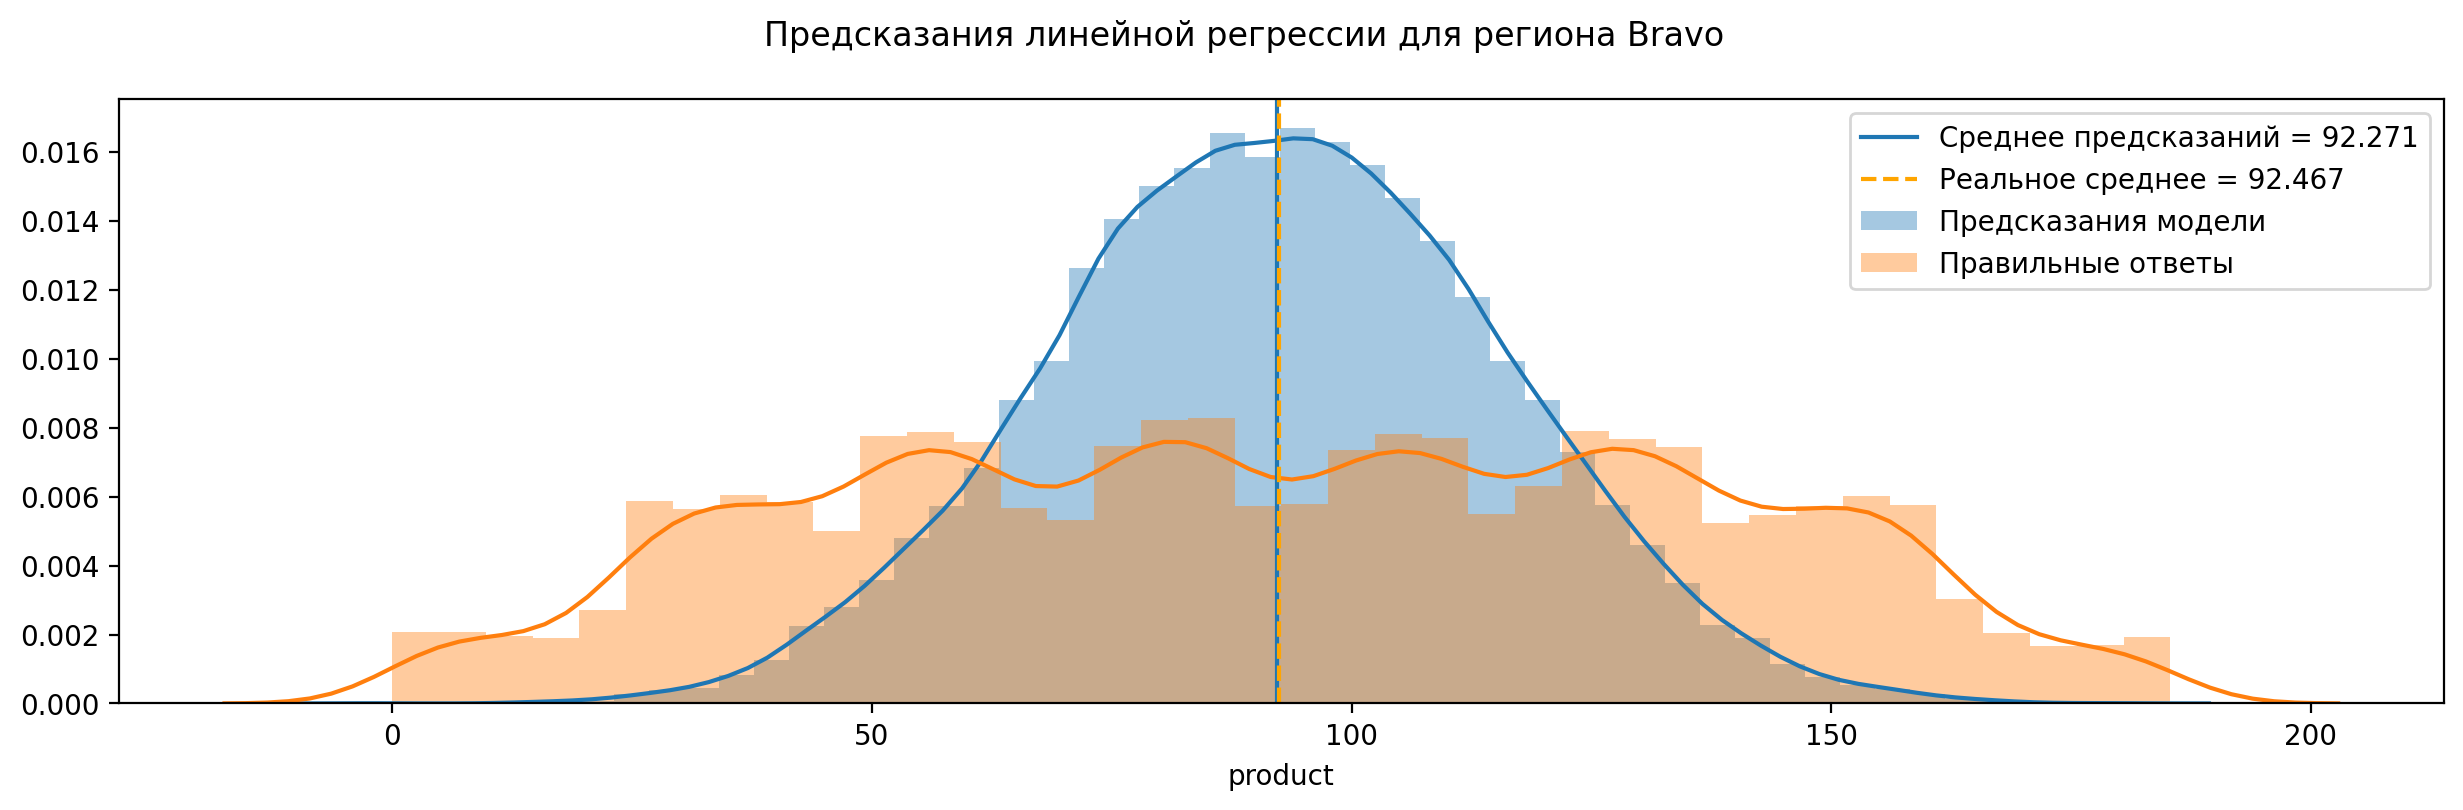

In [25]:
bravo_resume = resume(bravo_y_val, bravo_preds, graphic=True, title='Предсказания линейной регрессии для региона Bravo', as_dict=True)

- Пока что мы видим, что модель склонна предсказывать значения в более узком диапазоне и не захватывает самые края реального распределения.
- Зато мы получили нормальное распределение с математическим ожиданием почти в том же самом месте, где находится реальное среднее.
- Модель сработала как естественный фильтр выбросов.

У нас нет уверенности в том, что предсказания модели достаточно репрезентативны для того, чтобы описывать по ним запасы нефти. Проверим это тестом Стьюдента для нормальных распределений.

In [26]:
def hypo(test, alpha=0.05, oneside=False, verbose=True):
    """Сравнивает p-value с уровнем значимости. Проверяет гипотезу.
    
    alpha: уровень значимости
    
    oneside: делит p-value пополам
    
    show: печатает либо возвращает bool
    """
    if isinstance(test, tuple):
        pv = test[1]
    else:
        pv = test.pvalue if not oneside else test.pvalue / 2
    result = pv > alpha
    if verbose:
        print('p-value =', pv)
        print('p-value',
              '>' if result else '<',
              alpha)
    else:
        return result

In [27]:
import scipy.stats as st

In [28]:
hypo(st.ttest_ind(bravo_preds, bravo_y_val, equal_var=False))

p-value = 0.5363905643487719
p-value > 0.05


У нас не получилось опровергнуть тот факт, что средние выборок равны. Вероятность этого больще 50% для случайно взятой выборки. Поэтому будем доверять предсказаниям модели.

Проделаем то же самое с оставшимися регионами.

### Регион Sierra
Здесь мы видим сильную корреляцию `f2` с целевым признаком. Но для начала обучим простую модель.

In [29]:
model_sierra = LinearRegression().fit(sierra_x_train, sierra_y_train)

In [30]:
root_mean_squared_error(sierra_y_val, model_sierra.predict(sierra_x_val))

0.8872573052219325

- Микроскопическая ошибка по сравнению с моделью Bravo: надо думать, это связано с тем, что количество уникальных значений в выборке - 12.
- Ещё и корреляция в *99+%* с одним из признаков.

Теперь попробуем только с `f2`.

In [31]:
model_sierra_f2 = LinearRegression().fit(dframe(sierra_x_train.f2), sierra_y_train)

In [32]:
root_mean_squared_error(sierra_y_val, LinearRegression().fit(dframe(sierra_x_train.f2), sierra_y_train).predict(dframe(sierra_x_val.f2)))

1.5952569430727686

Опять же, стало менее точно. Выходит, что другие признаки так или иначе повышают точность предсказаний.

In [33]:
del model_sierra_f2

In [34]:
sierra_preds = pd.Series(model_sierra.predict(sierra_x_val), index = sierra_y_val.index)

In [35]:
sierra_preds.head()

3582     134.451381
60498    137.031555
53227      2.835624
21333    111.274297
3885     138.109072
dtype: float64

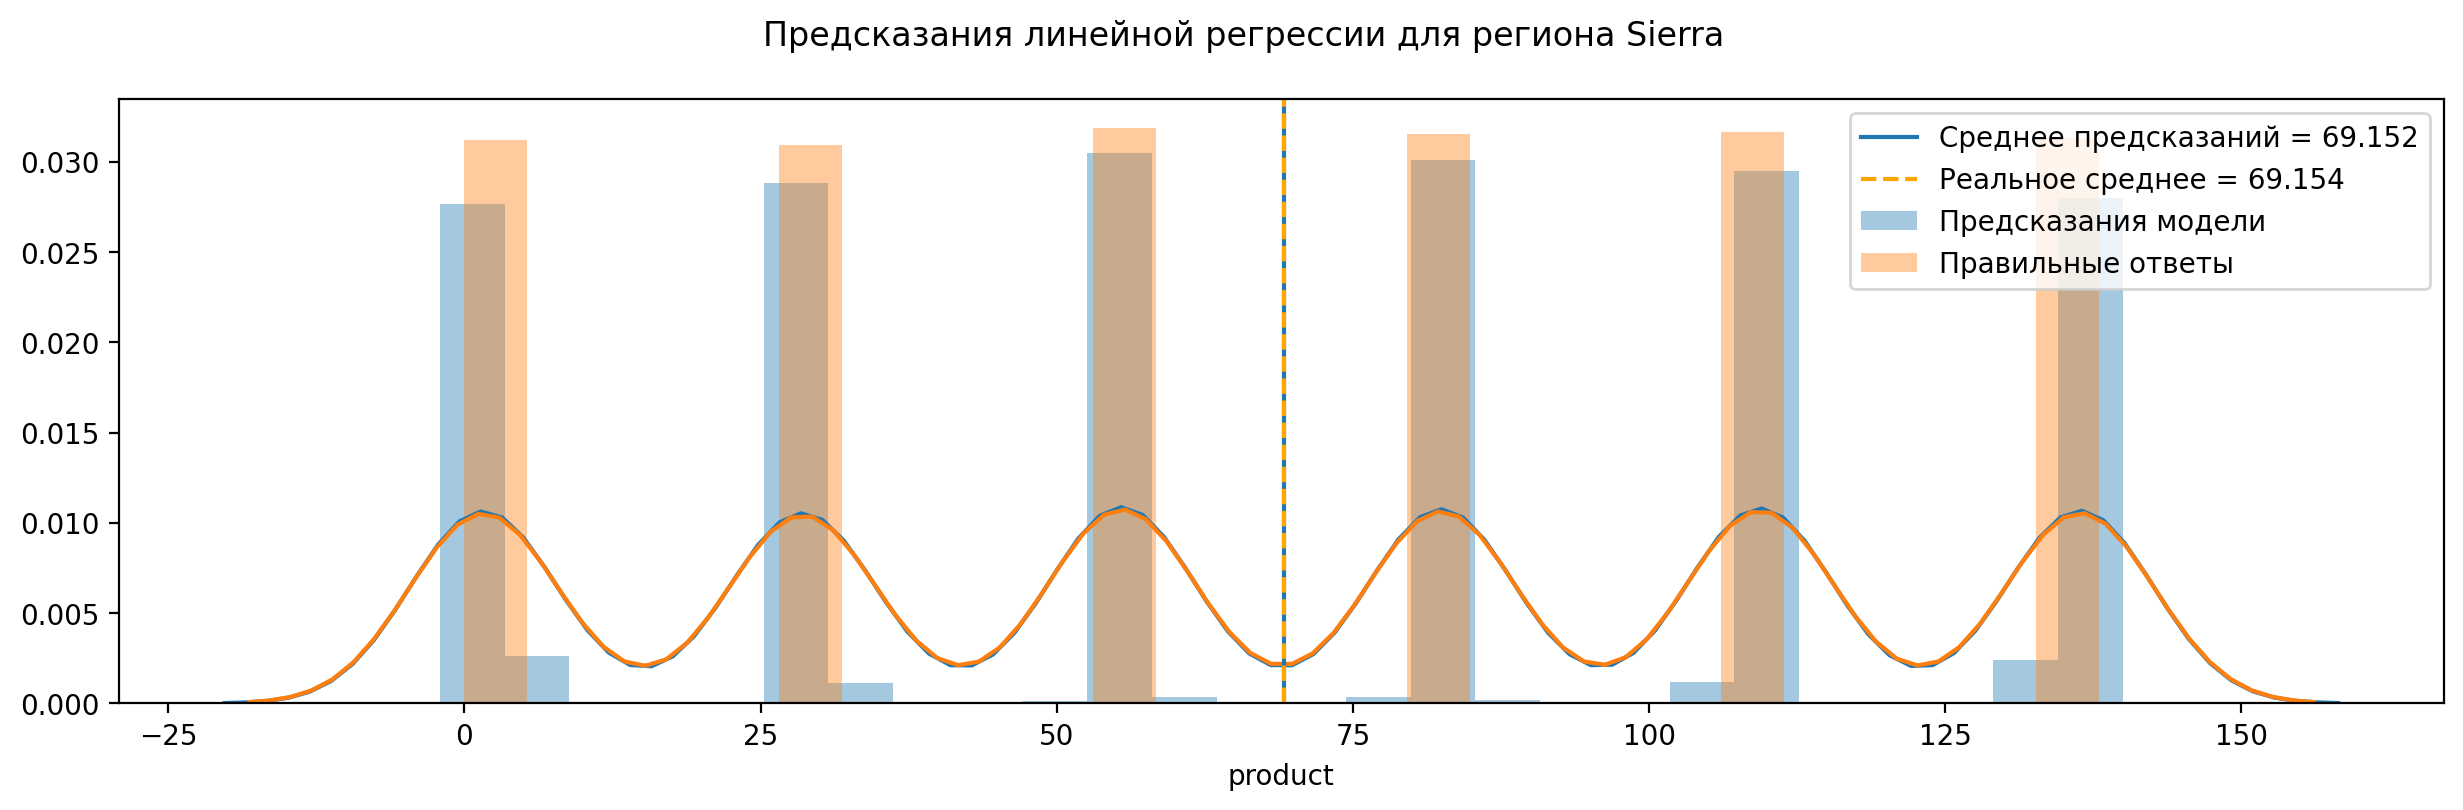

In [36]:
sierra_resume = resume(sierra_y_val, sierra_preds, graphic=True, title='Предсказания линейной регрессии для региона Sierra', as_dict=True)

- Предсказания модели чуть более нормально распределены, чем реальные величины.
- Среднее предсказаний и реальное среднее опять же мало чем отличаются.
- Предположим, что регрессия работает столь хорошо благодаря тому, что распределения признаков нормальные, и есть признак с высокой корреляцией.

Проверим гипотезу на сходство выборок.

In [37]:
hypo(st.ttest_ind(sierra_preds, sierra_y_val))

p-value = 0.9946872973896815
p-value > 0.05


Как мы и ожидали, модель отлично описала распределение.

### Регион Tango
Здесь мы обучим единственную модель без экспериментов с признаками.

In [38]:
model_tango = LinearRegression().fit(tango_x_train, tango_y_train)

In [39]:
tango_preds = pd.Series(model_tango.predict(tango_x_val), index = tango_y_val.index)

In [40]:
tango_preds.head()

3582     103.879759
60498     59.948159
53227    108.629782
21333     99.219377
3885      90.361944
dtype: float64

In [41]:
root_mean_squared_error(tango_y_val, tango_preds)

40.31290686044374

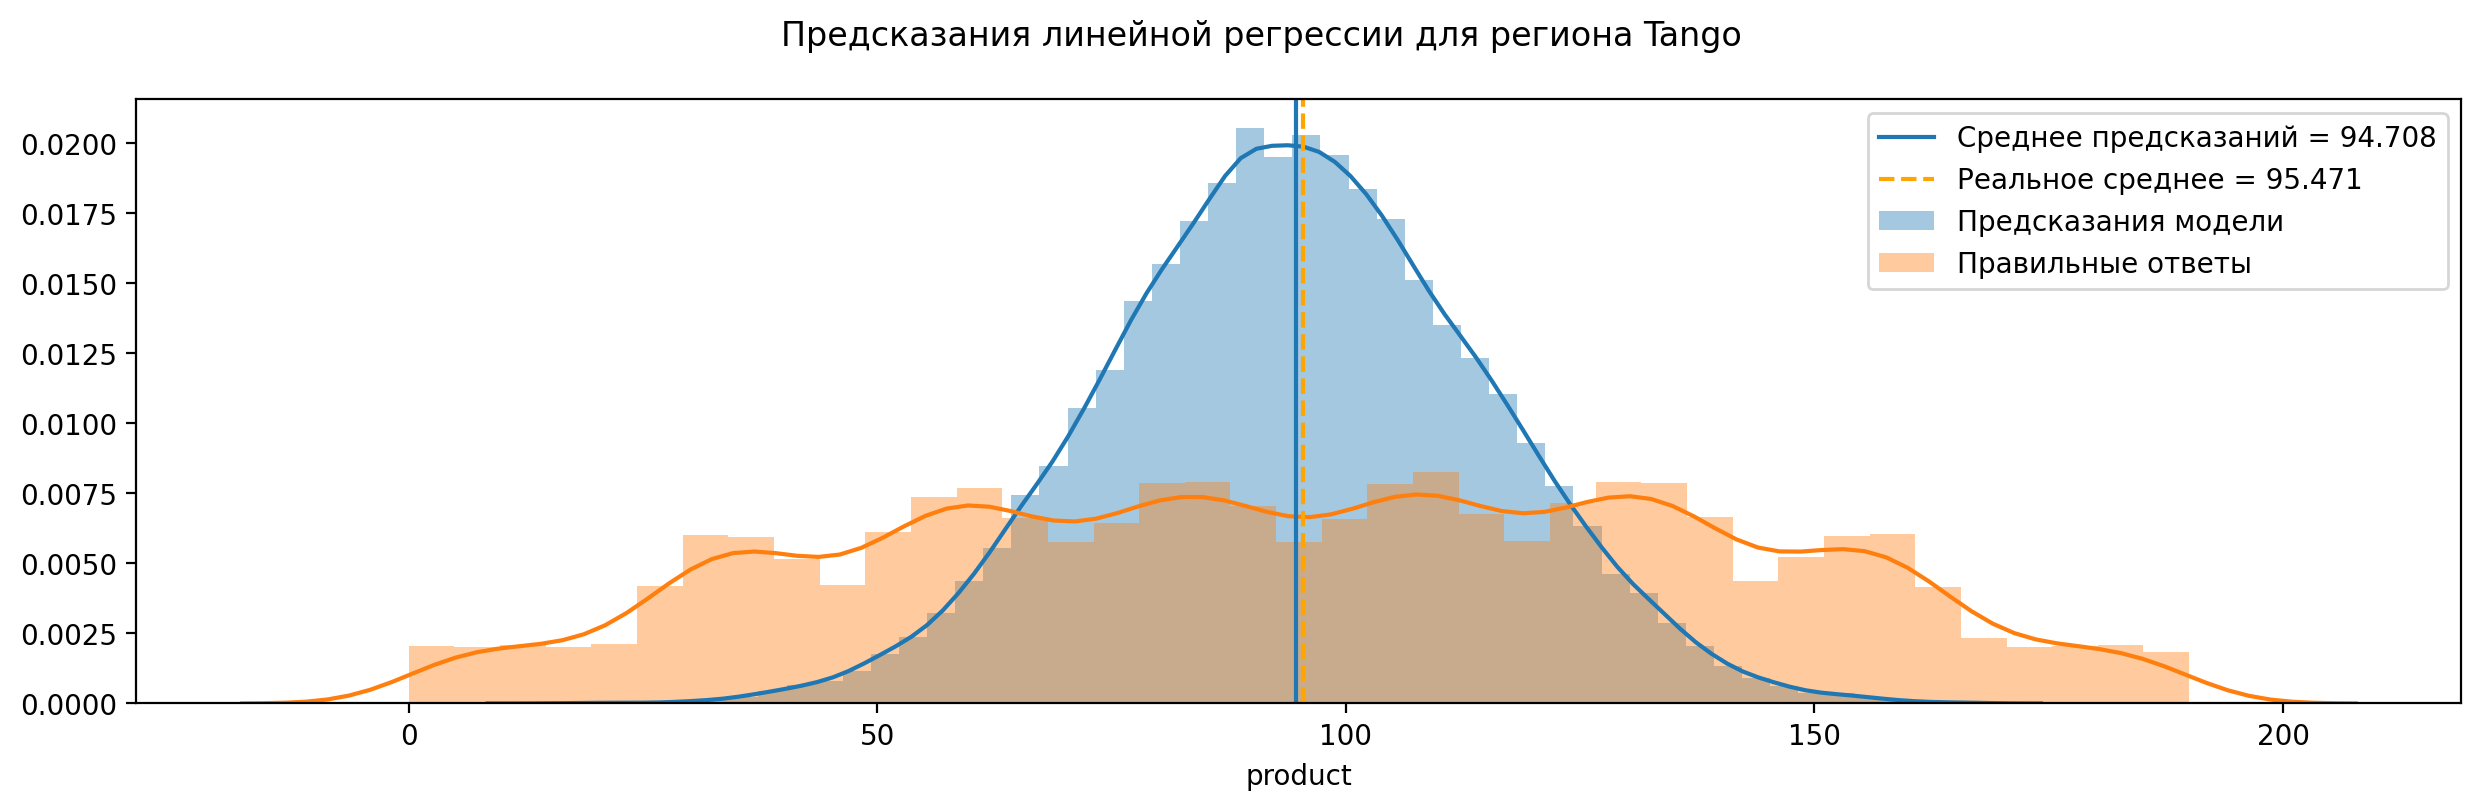

In [42]:
tango_resume = resume(tango_y_val, tango_preds, graphic=True, as_dict=True, title='Предсказания линейной регрессии для региона Tango')

Видим ситуацию, похожую на Bravo:
- Среднее предсказаний Tango совсем немного оптимистичнее, чем среднее предсказаний Bravo.
- RMSE модели на датасете Tango несколько выше.

Проверим гипотезу на равенство средних.

In [43]:
hypo(st.ttest_ind(tango_preds, tango_y_val))

p-value = 0.014001742404470517
p-value < 0.05


А вот здесь велика вероятность, что среднее предсказаний модели не будет сооветствовать правде. Вряд ли мы хорошо предскажем надёжность скважины - можем ошибиться: как переоценить, так и недооценить.

Отобразим результаты работы моделей графически.

In [44]:
resumes = dframe([bravo_resume, sierra_resume, tango_resume], index=names)
resumes

,rmse,preds_mean,true_mean
Bravo,37.481009,92.271449,92.466785
Sierra,0.887257,69.151624,69.154361
Tango,40.312907,94.707531,95.471317


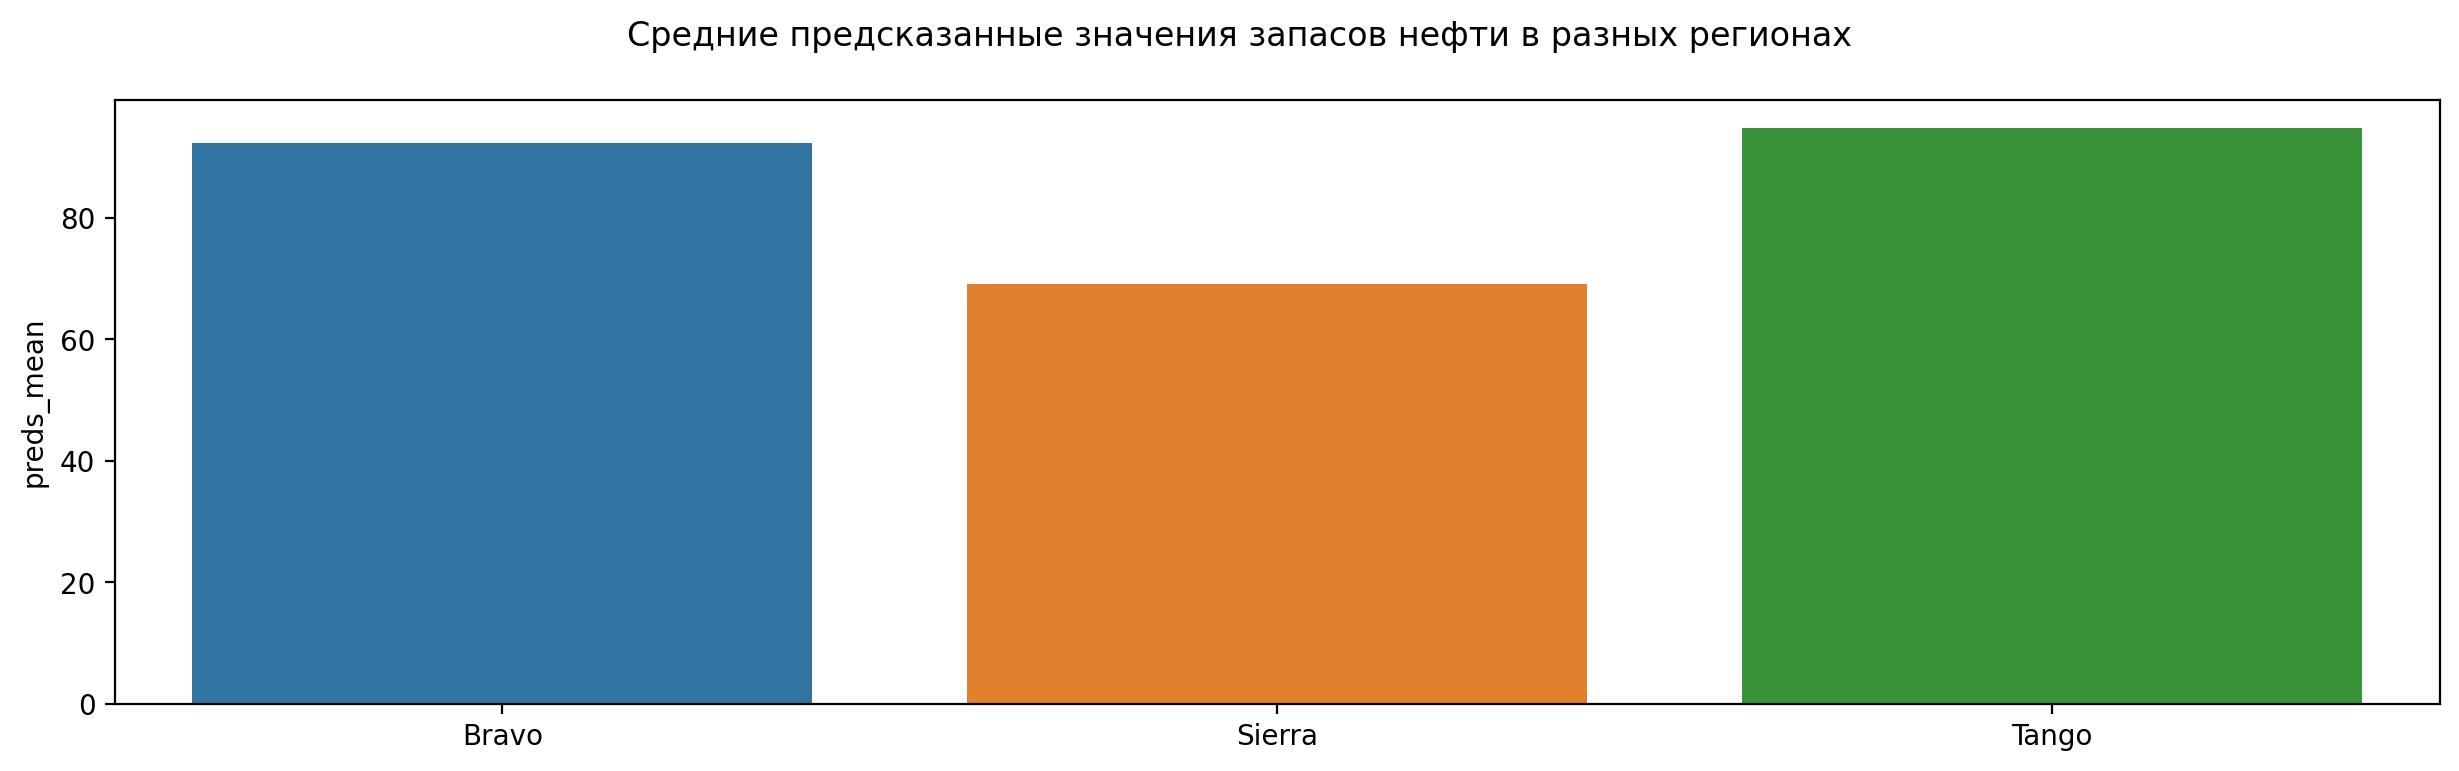

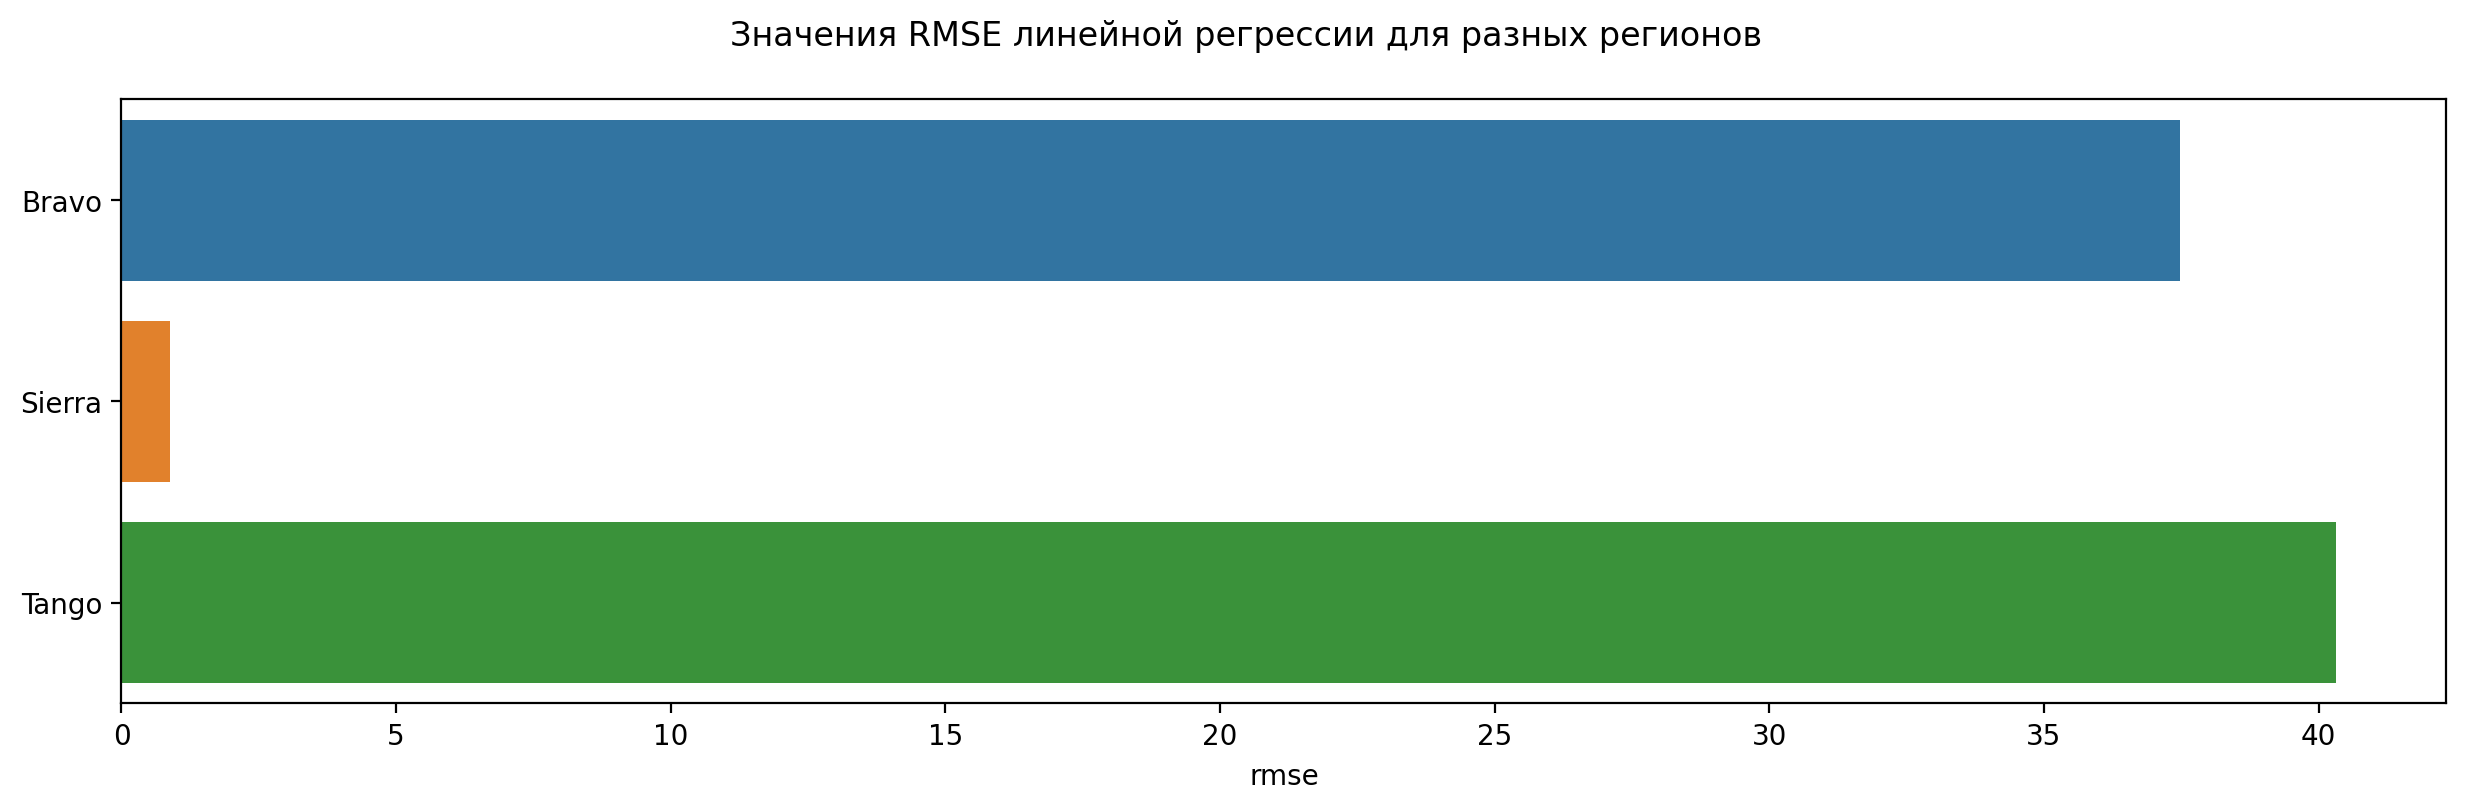

In [45]:
with Plotter(st='Средние предсказанные значения запасов нефти в разных регионах'):
    sns.barplot(resumes.index, resumes.preds_mean, )
with Plotter(st='Значения RMSE линейной регрессии для разных регионов'):
    sns.barplot(resumes.rmse, resumes.index)

Из диаграмм видим:
- В среднем предсказанные значения запасов выше в регионах Bravo и Tango.
- Для Sierra предсказанное моделью ожидание ниже.
- RMSE регионов Bravo и Tango выше, чем в Sierra. Возможно, что средние случайно взятых выборок из этих регионов будут различаться больше, чем в Sierra.

### Вывод из обучения линейной регрессии
- Мы обучили отдельные модели для каждого региона.
- Сделали предсказания запасов нефти для валидационной выборки по каждому месторождению.
- Оценили качество моделей метрикой RMSE.
- Попробовали обучить модели Bravo и Sierra, убрав некоторые признаки. Качество несколько ухудшилось, поэтому мы оставили варианты моделей, обученные на полных данных.
- Сопоставили средние предсказаний с реальными средними. Различие во всех случаях минимальное. Модели склонны к чуть более пессимистичному среднему.
- Вывели диаграммы по результатам предсказаний, сравнили средние предсказаний всех регионов и RMSE моделей на валидационных выборках.

Пока что наиболее перспективным вариантом для нас выглядят регионы Bravo и Tango, потому что их средние предсказанные значения запасов выше, чем среднее в Sierra.

---

***Вопрос к уважаемому ревьюеру***

Насколько я понимаю, мы при помощи модели создали некий слепок распределения, который будет плюс-минус точно описывать наши запасы нефти? Почему мы не берём для этого исходные датасеты с готовыми ответами? Мы предполагаем, что у нас этих ответов нет, и для этого обучаем модель, которая решит, какие скважины лучше по её мнению?

---

## 3. Подготовка к расчёту прибыли
Выпишем значения для расчётов из условий задачи.

In [46]:
# При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли
sample_size = 500
top_count = 200

# Бюджет на разработку скважин в регионе — 10 млрд рублей
max_budget = 10e9

# Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
product_price = 450e3

# После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью
alpha = 0.025

Посчитаем, каким будет минимальный суммарный запас сырья в регионе, чтобы разработка не стала для нас убыточной. Для этого выручка не должна быть меньше *10 млрд.р.*

Разделим минимальную выручку на цену одной тысячи баррелей.

In [47]:
min_prod_region = max_budget / product_price
min_prod_region

22222.222222222223

Выходит, что в среднем одна скважина должна обеспечивать:

In [48]:
min_product_mean = min_prod_region / 200
min_product_mean

111.11111111111111

Посмотрим, насколько это реалистично для наших предсказанных средних.

In [49]:
resumes

,rmse,preds_mean,true_mean
Bravo,37.481009,92.271449,92.466785
Sierra,0.887257,69.151624,69.154361
Tango,40.312907,94.707531,95.471317


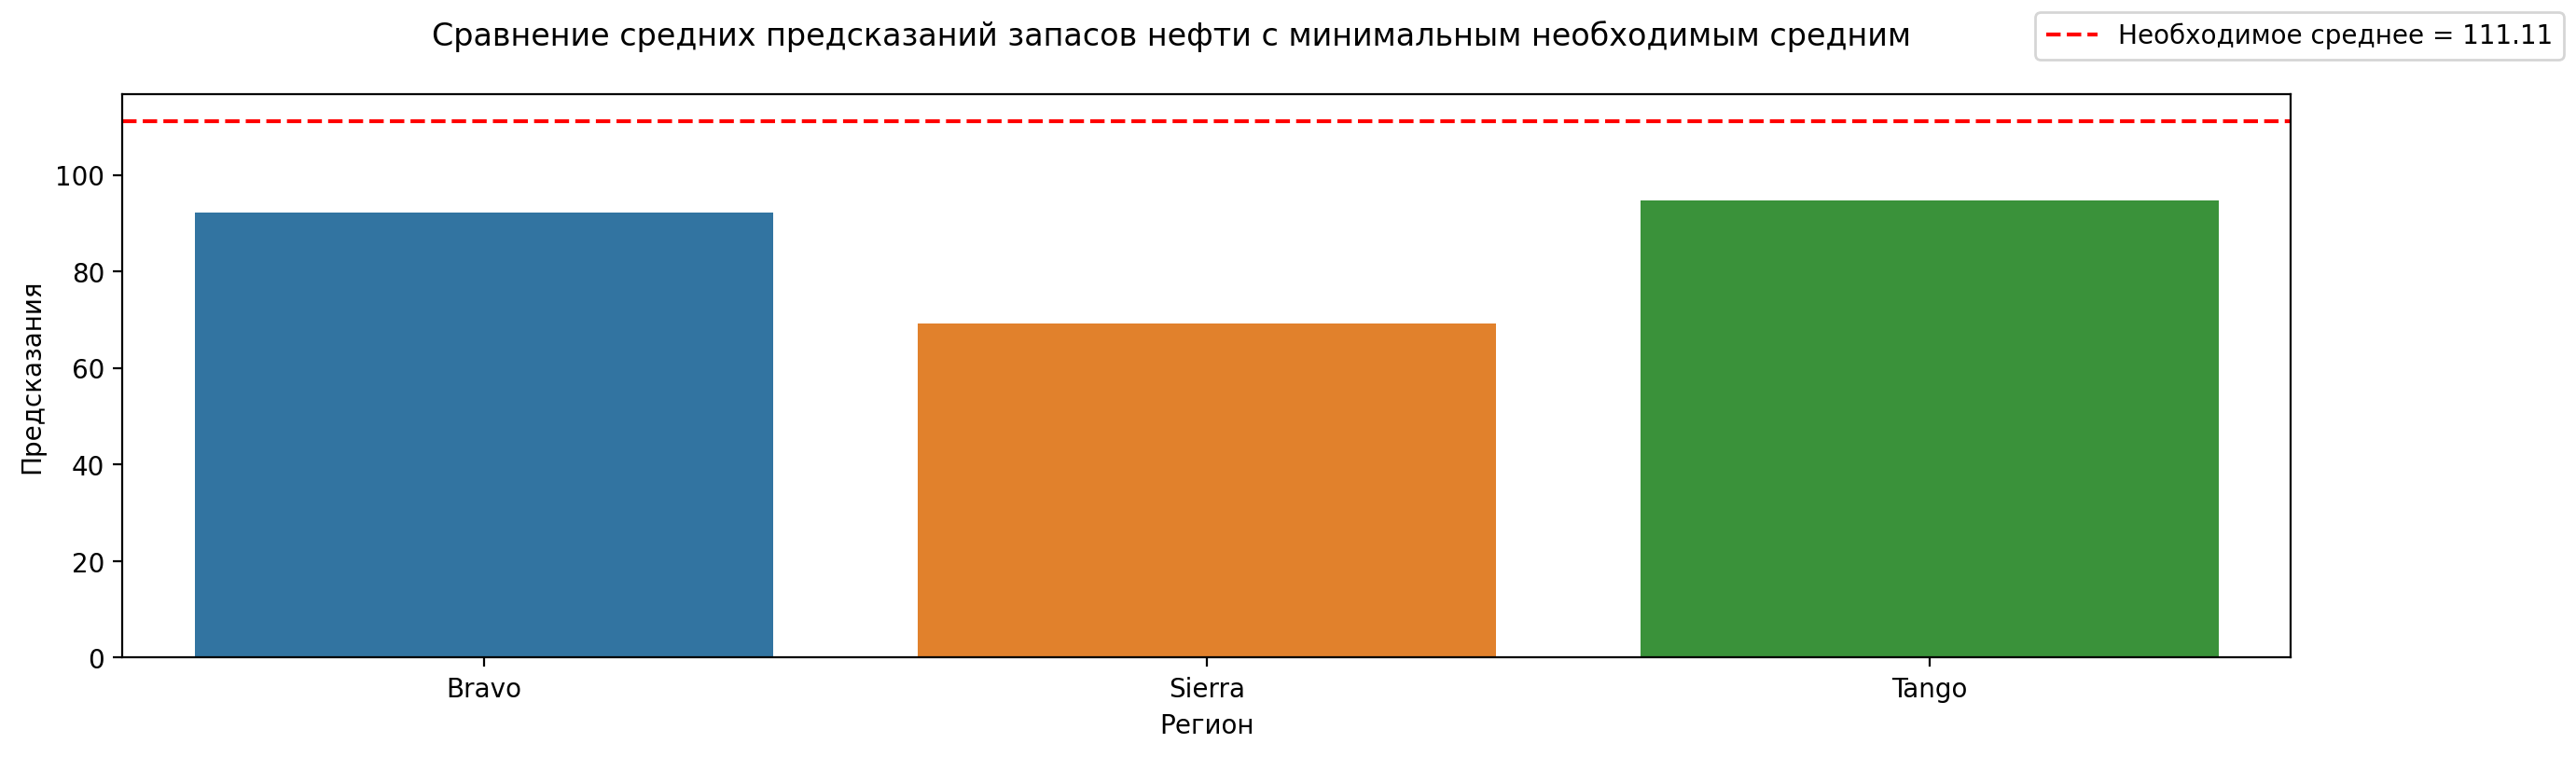

In [50]:
with Plotter(st='Сравнение средних предсказаний запасов нефти с минимальным необходимым средним', legend='f'):
    sns.barplot(resumes.index, resumes.preds_mean)
    plt.axhline(min_product_mean, c='r', ls='--', label=f'Необходимое среднее = {min_product_mean:.2f}')
    Plotter.labels('Регион', 'Предсказания')

- Похоже, что ориентироваться на среднее для нас будет недостаточно ни в каком регионе. *Нужно больше нефти*.
- Чтобы перекрыть расходы на разработку месторождений, нам понадобятся самые лучшие скважины.

## 4. Расчёт прибыли и рисков 
Для начала мы напишем формулу, которая будет находить лучшие скважины из выборки, основываясь на оценке модели.

In [51]:
def profit(preds, true, n, price, budget):
    """Получает на вход предсказания, выбирает лучшие индексы и считает прибыль: n лучших скважин * стоимость единицы - затраты на разработку"""
    return sum(true[preds.sort_values(ascending=False)[:n].index]) * price - budget

### Bootstrap
Применим бутстреп для нахождения распределения прибыли. Так мы поймём, какие у нас перспективы при нашем подходе к разработке месторождений.

In [52]:
# Зафиксируем случайное состояние для повторяемости экспериментов
rstate = np.random.RandomState(0)

profits = [pd.Series([profit(pd.Series(preds).sample(sample_size, random_state=rstate, replace=True), true, top_count, product_price, max_budget) for i in range(1000)])
           for preds, true in zip([bravo_preds, sierra_preds, tango_preds],
                                  [bravo_y_val, sierra_y_val, tango_y_val])]

Вычислим границы 95% доверительного интервала для средней прибыли в каждом регионе.

In [53]:
intervals = dframe(({'lower': pf.quantile(0.025), 'upper': pf.quantile(0.975)} for pf in profits), index=names)

In [54]:
intervals.sort_values('lower', ascending=False)

,lower,upper
Sierra,8.517891e+07,8.508946e+08
Bravo,-4.923499e+07,9.211347e+08
Tango,-1.510246e+08,9.167979e+08


Видим по таблице, что:
- Только в регионе Sierra в наш 95%-й доверительный интервал не попадают отрицательные значения прибыли. Это означает, что шансы попасть на безубыточный набор скважин в регионах Bravo и Tango явно ниже 95%, а в  Sierra мы с очень большой долей вероятности ткнём пальцем в землю(🙂) и попадём в прибыльные места.
- Однако у Sierra есть и обратная сторона медали: верхняя граница доверительного интервала 95% ниже, чем в Bravo или Tango. Соответственно, в Sierra у нас не такие высокие шансы получить прибыль, возможную в двух других местах.
- Пока что оптимальными вариантами кажутся регионы Sierra и Bravo, потому что в регионе Tango нижняя граница доверительного интервала на целый порядок ниже, чем в Bravo. Да и возможный доход ниже. Держим в уме: *Tango - наименее надёжный вариант*.

Посчитаем для каждого региона риск убытков - то есть долю экспериментов с отрицательной прибылью.

In [55]:
# Отбираем эксперименты < 0 и делим их на общее число наблюдений для каждого региона
risks = pd.Series([len([exp for exp in pf if exp < 0]) / len(pf)
                   for pf in profits],
                  index=names, name='risks')
risks.sort_values()

Sierra    0.008
Bravo     0.039
Tango     0.069
Name: risks, dtype: float64

- Sierra внушает наибольшее доверие, поскольку риски, связанные с эти регионом, меньше всего.
- Tango вновь оказывается наименее выигрышным предприятием.

В итоге у нас получается вот такая таблица с оценкой надёжности регионов.

In [56]:
pd.concat([intervals, risks], axis=1).sort_values('risks')

,lower,upper,risks
Sierra,8.517891e+07,8.508946e+08,0.008
Bravo,-4.923499e+07,9.211347e+08,0.039
Tango,-1.510246e+08,9.167979e+08,0.069


Дополним наши соображения гистограммами и ящиками с усами. Вместе они дадут нам лучшее понимание.

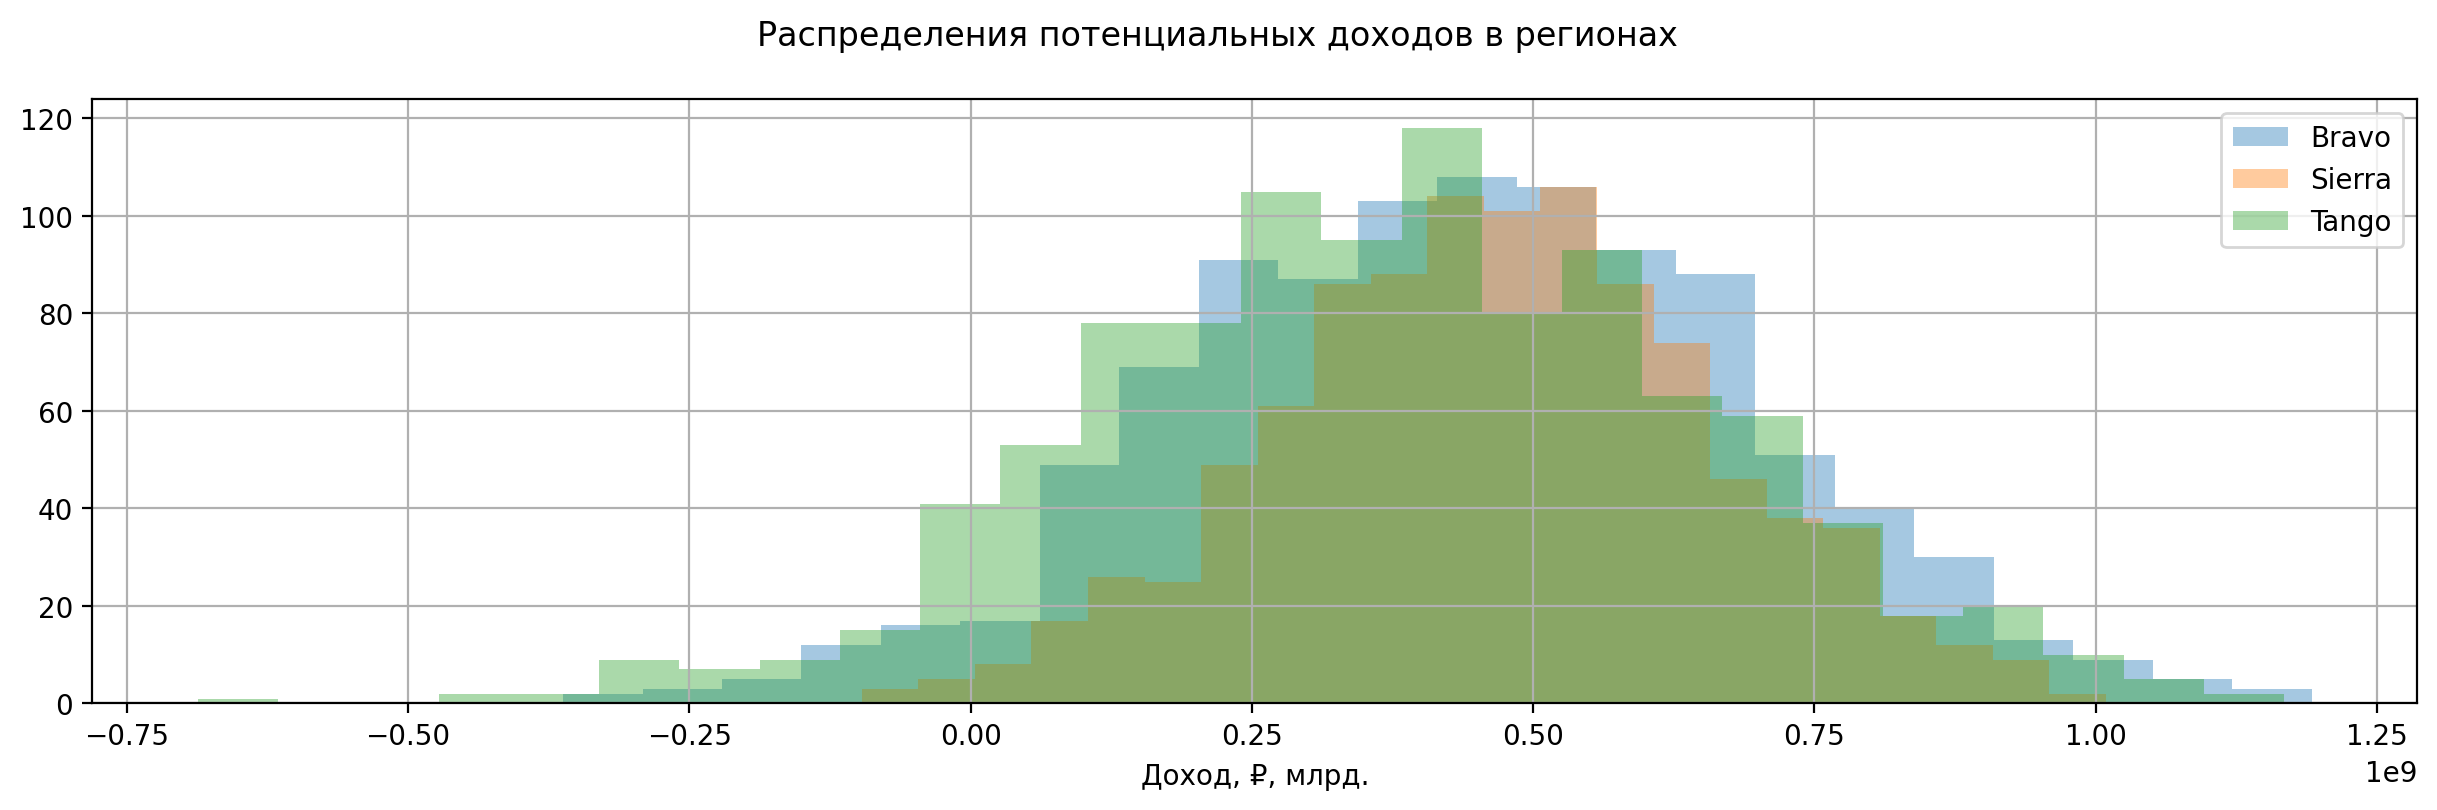

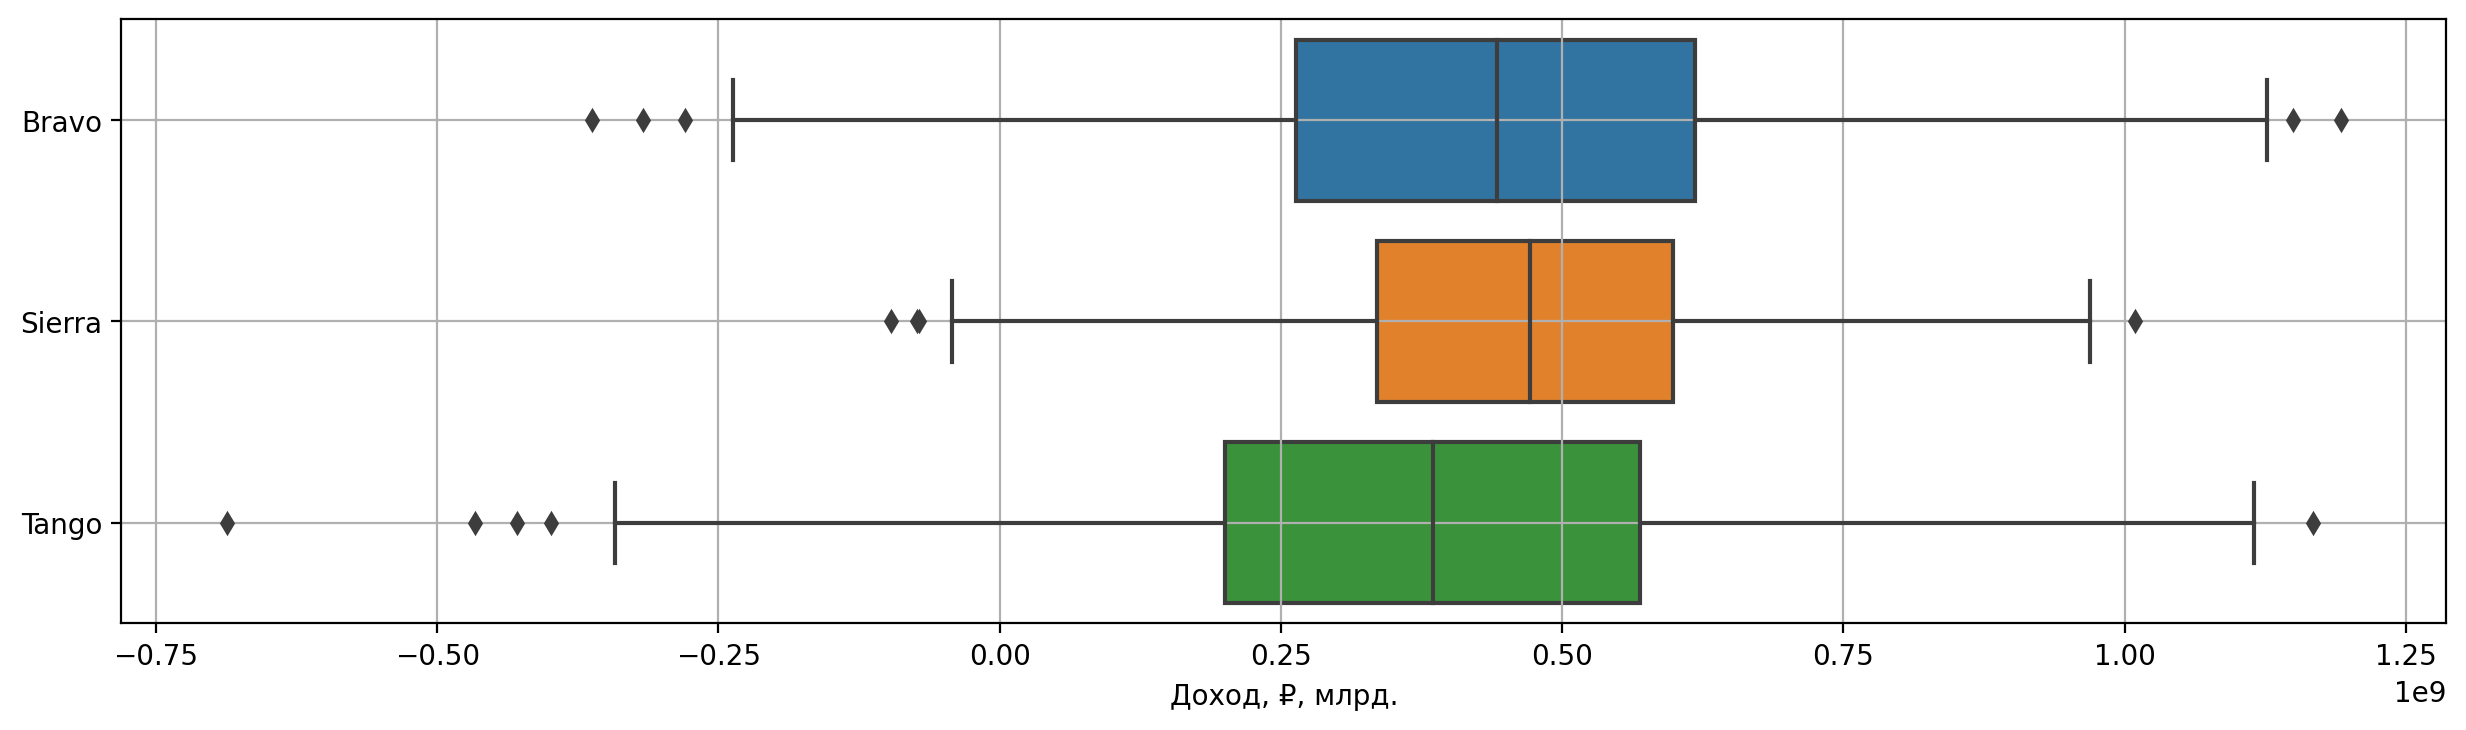

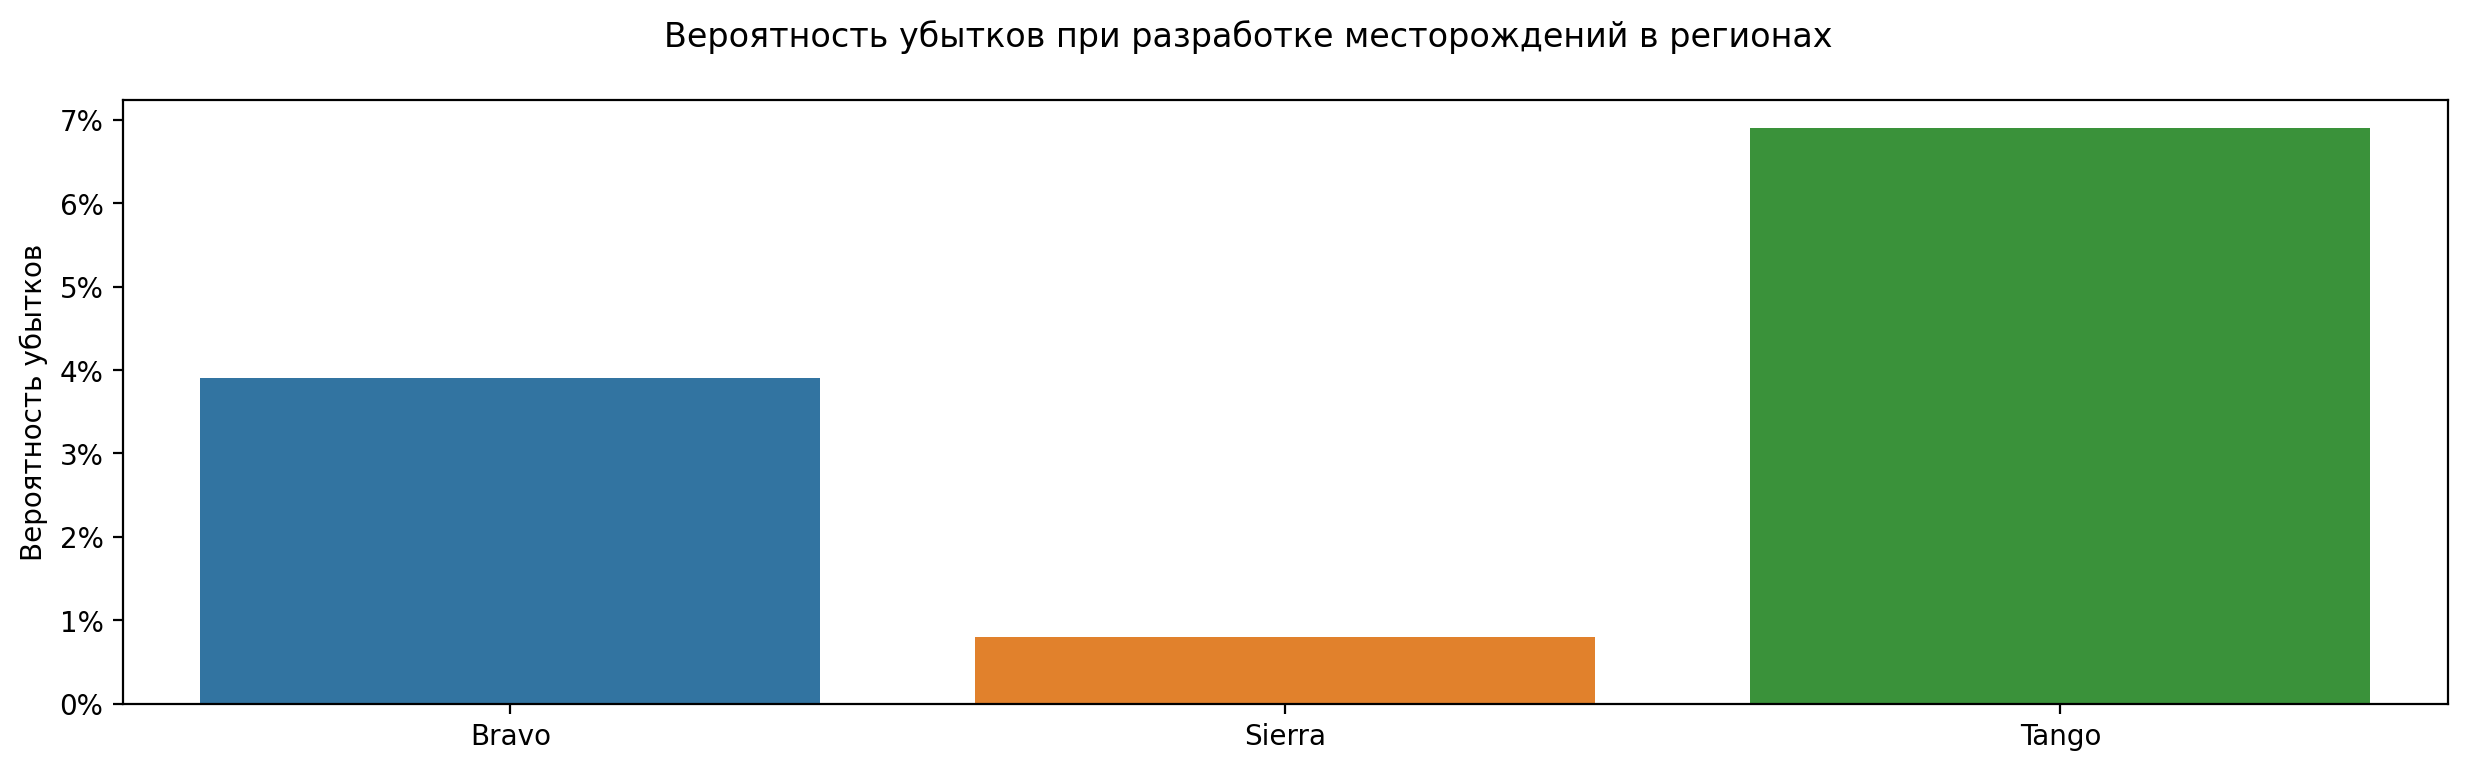

In [57]:
from matplotlib.ticker import PercentFormatter

with Plotter(st='Распределения потенциальных доходов в регионах', legend='a', grid=True):
    for pf, name in zip(profits, names):
        sns.distplot(pf, label=name, kde=False)
    Plotter.labels(x='Доход, ₽, млрд.')
with Plotter(grid=True):
    sns.boxplot(data=dframe(dict(zip(names, profits))), orient='h')
    Plotter.labels(x='Доход, ₽, млрд.')
with Plotter(st='Вероятность убытков при разработке месторождений в регионах'):
    sns.barplot(risks.index, risks)
    Plotter.format_axis(1, PercentFormatter(1, decimals=0))
    Plotter.labels(y='Вероятность убытков')

Глазами видим:
- Распределение Sierra является наиболее оптимальным даже на гистограмме. Sierra реже остальных "заезжает" в убыточную зону, но и потенциальный доход ниже.
- Наибольший потенциальный доход у Bravo.
- Наибольшая вероятность попасть на убытки - у Tango.

---

## 5. Выбор региона
Мы оценили возможный доход/убытки, связанные с разработкой месторождений в трёх регионах. Чтобы выбрать оптимальный регион, нам нужно понимать, насколько компания готова к рискам в виде возможных убытков, и здесь есть два варианта:
- **Компания готова к возможным убыткам** - в таком случае интереснее будет рассмотреть **Bravo**, поскольку потенциальная доходность будет максимальной, а вероятность убытка - минимально возможной.
- **Компания рассчитывает только на прибыль** - тогда мы рекомендуем регион **Sierra**: компания получит прибыль более, чем с 95% вероятностью, хоть и не сможет рассчитывать на джекпот в отношении прибыли.

Если бы мы могли выбрать только один регион, то, руководствуясь принципом *\"тише едешь - дальше будешь\"*, мы выбираем **Sierra**.

---

## 6. Общий вывод
- Мы обучили модели линейной регрессии, оценивающие запас сырья в скважинах для трёх разных регионов. Цель этого - выявить потенциально лучшие скважины в регионе при условии, что на деле мы сможем охватить лишь небольшую их часть на имеющийся бюджет.
- Написали функцию, в которой мы берём лучшие по мнению модели скважины и считаем доход от них по реальным значениям запасов. Это служит своеобразной проверкой модели в реальных условиях, как если бы мы на самом деле ничего не знали о фактических запасах нефти в скважинах.
- Использовали технику bootstrap, чтобы смоделировать распределение потенциальной прибыли от разных регионов c учётом нашего бюджета и возможностей для разработки.
- По полученному распределению определили:
    - Среднюю прибыль, на которую мы можем рассчитывать.
    - Доверительный интервал - границы диапазона значений, в который с 95% вероятностью окажется наша прибыль.
    - Вероятность отрицательной прибыли, то есть убытков.
- Проанализировали вышенайденные показатели регионов и пришли к выводу, что наиболее оптимальный вариант - это регион **Sierra**, поскольку он меньше прочих сопряжён с рисками. **Bravo** понравился нам потенциальной прибылью, но вероятность убытков в нём больше. Регион **Tango** мы не стали рекомендовать, потому что у него нет преимуществ перед двумя другими.

Заключим, что наша модель неплохо справилась со своей задачей - оценкой качества месторождений. Мы можем доверять ей выбор подходящего места для разработки. А это отличная новость!

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован

---

In [79]:
def first_look(df) -> None:
    for df, name in locations:
        print(name + '\n' + '-' * 50)
        loc.info()
        print('-' * 50)
        print('head()')
        display(loc.head(3))
        print('-' * 50)
        print('nunique()')
        display(loc.nunique())
        print('-' * 50)
        print('describe()')
        display(loc.describe().transpose())
        print('-' * 50)
        print('corr()')
        display(loc.corr())
        sns.pairplot(loc)
        Plotter().show(st=f'Распределения и зависимости признаков в регионе "{name}"', tight=True)
        print()

In [ ]:
first_look

In [ ]:
profit()

### Функция для бутстрепа

In [82]:
bravo_y_val

3582      49.723143
60498     10.583795
53227    139.110613
21333     85.109875
3885      39.726827
            ...    
26543     76.153285
85764    106.056701
87585    145.473737
32519     45.110088
18831     86.175884
Name: product, Length: 25000, dtype: float64

In [86]:
bravo_preds = pd.Series(model_bravo.predict(bravo_x_val), index=bravo_y_val.index)
bravo_preds

3582      95.303891
60498     95.098407
53227    106.702273
21333     96.740059
3885      97.703381
            ...    
26543     98.031394
85764    124.436693
87585    120.705141
32519     88.129874
18831     81.381282
Length: 25000, dtype: float64

In [147]:
def true_profit(preds, true, top=200, budget=10e9, price=450e3) -> int:
    preds_sorted = preds.sort_values(ascending=False)[:top].index
    true_top = true[preds_sorted]
    return sum(true_top) * price - budget

In [143]:
# Прибыли
profits_bravo, profits_sierra, profits_tango = [], [], []

rstate = np.random.RandomState(5)
for i in range(1000):
    profits_bravo.append(true_profit(bravo_preds.sample(500, replace=True), bravo_y_val))
    profits_sierra.append(true_profit(sierra_preds.sample(500, replace=True), sierra_y_val))

profits_bravo, profits_sierra = [pd.Series(x) for x in (profits_bravo, profits_sierra)]

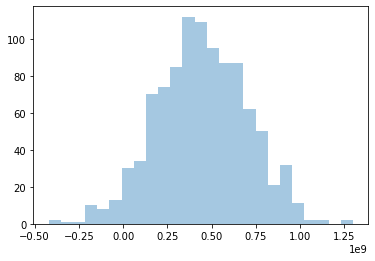

In [142]:
sns.distplot(profits_bravo, kde=False)

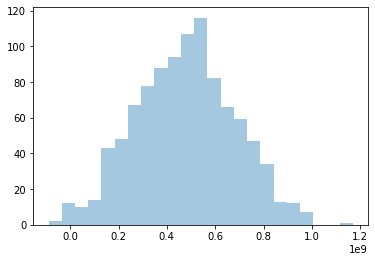

In [146]:
sns.distplot(profits_sierra, kde=False)